In [1]:
import pandas as pd
import geopandas as gd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
import rasterio
import rasterio.warp
from rasterio import features
import shapely.geometry
import shapely
import seaborn as sn

In [2]:
os.chdir('/projects/canis/eoc_feature_corr')

In [3]:
grid_path = "./data/by_state/ME/me_extent_coverage.shp"
grid = gd.read_file(grid_path)
grid = grid.set_index('id')

In [4]:
original_feature_path = './data/form/landforms_10classes_30m_dd83.img'

feature_file = rasterio.open(original_feature_path)
feature_raster = feature_file.read(1)

In [5]:
dst_crs = rasterio.crs.CRS.from_epsg(3857)

In [6]:
transform, width, height = rasterio.warp.calculate_default_transform(
    feature_file.crs, dst_crs, feature_file.width,
    feature_file.height, *feature_file.bounds)
kwargs = feature_file.meta.copy()
kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

dst = './data/form/landforms_10classes_30m_dd83_3857.tiff'

with rasterio.open(dst, 'w', **kwargs) as dst:
    rasterio.warp.reproject(
        source=rasterio.band(feature_file, 1),
        destination=rasterio.band(dst, 1),
        src_transform=feature_file.transform,
        src_crs=feature_file.crs,
        dst_transform=transform,
        dst_crs=dst_crs,
        resampling=rasterio.warp.Resampling.nearest)

In [4]:
feature_path = './data/cover/landforms_10classes_30m_dd83_3857.tiff'

feature_file = rasterio.open(feature_path)
feature_raster = feature_file.read(1)

In [5]:
grid['centroid'] = grid['geometry'].centroid
grid = grid.set_geometry('centroid')
grid['feature'] = grid['centroid'].map(lambda coords: next(feature_file.sample(coords.coords, indexes=1))[0])
grid = grid.set_geometry('geometry')
grid = grid.drop('centroid', axis=1)
grid

,left,top,right,bottom,med_rxpwr,chg_covera,verizon_co,geometry,feature
id,,,,,,,,,
462.0,-7.855368e+06,5.525930e+06,-7.854368e+06,5.524930e+06,-96.055,1,1,"POLYGON ((-7855367.514 5525929.661, -7854367.5...",7
463.0,-7.855368e+06,5.524930e+06,-7.854368e+06,5.523930e+06,-102.590,1,1,"POLYGON ((-7855367.514 5524929.661, -7854367.5...",10
464.0,-7.855368e+06,5.523930e+06,-7.854368e+06,5.522930e+06,-99.260,1,1,"POLYGON ((-7855367.514 5523929.661, -7854367.5...",7
467.0,-7.855368e+06,5.520930e+06,-7.854368e+06,5.519930e+06,-84.250,1,1,"POLYGON ((-7855367.514 5520929.661, -7854367.5...",3
1001.0,-7.854368e+06,5.523930e+06,-7.853368e+06,5.522930e+06,-95.550,1,1,"POLYGON ((-7854367.514 5523929.661, -7853367.5...",8
...,...,...,...,...,...,...,...,...,...
206582.0,-7.471368e+06,5.613930e+06,-7.470368e+06,5.612930e+06,-120.540,0,0,"POLYGON ((-7471367.514 5613929.661, -7470367.5...",3
207118.0,-7.470368e+06,5.614930e+06,-7.469368e+06,5.613930e+06,-117.160,0,0,"POLYGON ((-7470367.514 5614929.661, -7469367.5...",3
207119.0,-7.470368e+06,5.613930e+06,-7.469368e+06,5.612930e+06,-123.710,0,0,"POLYGON ((-7470367.514 5613929.661, -7469367.5...",0


In [6]:
grid['agreement'] = grid['chg_covera'] == grid['verizon_co']

In [7]:
sn.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

In [8]:
confusion_matrix = pd.crosstab( grid['feature'],grid['agreement'], rownames=['Form Type'], colnames=['Agreement'], normalize='index')
print (confusion_matrix)

Agreement     False     True 
Form Type                    
0          0.350000  0.650000
1          0.568966  0.431034
2          0.562914  0.437086
3          0.574094  0.425906
4          0.537634  0.462366
6          0.588235  0.411765
7          0.547368  0.452632
8          0.581967  0.418033
10         0.561955  0.438045


In [9]:
confusion_matrix['Total'] = grid.groupby('feature').count()['agreement']

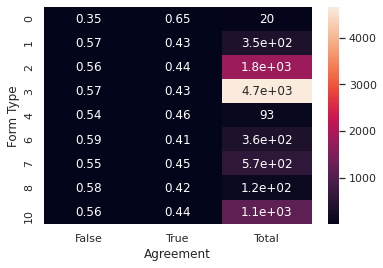

In [10]:
sn.heatmap(confusion_matrix, annot=True)
plt.show()

Agreement   False  True   All
Cover Type                   
0               7    13    20
1             198   150   348
2            1020   792  1812
3            2677  1986  4663
4              50    43    93
6             210   147   357
7             312   258   570
8              71    51   122
10            644   502  1146
All          5189  3942  9131


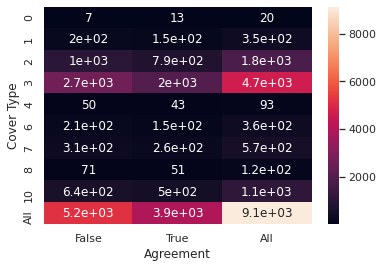

In [11]:
confusion_matrix = pd.crosstab( grid['feature'],grid['agreement'], rownames=['Cover Type'], colnames=['Agreement'], margins=True)
print (confusion_matrix)
sn.heatmap(confusion_matrix, annot=True)
plt.show()